In [1]:
%load_ext autoreload
%autoreload 2
import os
import glob
import cv2

import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
import json  # Added to initialize the setting in Jupyter Notebook-by Mingyang
import easydict  # Added to initialize the setting in Jupyter Notebook-by Mingyang
import random
import numpy as np
import nltk
import string
from PIL import Image

from geneva.models.models import INFERENCE_MODELS
from geneva.data.datasets import DATASETS
from geneva.evaluation.evaluate import Evaluator
from geneva.utils.config import keys, parse_config
from geneva.utils.visualize import VisdomPlotter
from geneva.models.models import MODELS
from geneva.data import codraw_dataset
from geneva.data import clevr_dataset
from geneva.data import gandraw_dataset
from geneva.evaluation.seg_scene_similarity_score import report_gandraw_eval_result
from geneva.utils.config import keys
from math import sqrt
import json

/home/zmykevin/CoDraw_Gaugan/code/GanDraw/GeNeVA/geneva/utils/config.py:15: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  keys = yaml.load(f)


In [2]:
def _parse_glove(glove_path):
    glove = {}
    with open(glove_path, 'r') as f:
        for line in f:
            splitline = line.split()
            word = splitline[0]
            embedding = np.array([float(val) for val in splitline[1:]])
            glove[word] = embedding

    return glove

class GanDraw_Talkative_Drawer():
    def __init__(self, cfg, pretrained_model_path=None, iteration=1000):
        self.cfg = cfg
        #Load the Dataset
        dataset_path = cfg.test_dataset
        gandraw_vocab_path = "/home/zmykevin/CoDraw_Gaugan/data/GanDraw/data_full_filtered/gandraw_vocab.txt"
        with open(gandraw_vocab_path, 'r') as f:
            gandraw_vocab = f.readlines()
            gandraw_vocab = [x.strip().rsplit(' ', 1)[0] for x in gandraw_vocab]        
        self.vocab = ['<s_start>', '<s_end>', '<unk>', '<pad>', '<d_end>'] + gandraw_vocab        
        self.cfg.vocab_size = len(self.vocab)
        
        self.model = INFERENCE_MODELS[self.cfg.gan_type](self.cfg)
        #load the pretrained_model
        if pretrained_model_path is not None:
            self.model.load(pretrained_model_path,iteration)
            
        self.current_iteration=iteration
        
        
        self.visualize_batch = 0
        # Keep all the progress images to be processed.
        self.visualize_images = []
        
        self.default_drawer_utt = ["okay", "done", "next"]
        self.glove = _parse_glove(keys['glove_gandraw_path'])
        self.unk_embedding = np.load("unk_embedding.npy")
        self.get_background_embedding()
        
        self.word2index = {k: v for v, k in enumerate(self.vocab)}
        self.index2word = {v: k for v, k in enumerate(self.vocab)}
        self.prev_utt = None
    def get_background_embedding(self):
        self.background_embedding = np.zeros((self.cfg.img_size, self.cfg.img_size, 22), dtype=np.int32)
        self.background_embedding[:,:,0] = 1 #Define the background with sky label activated
        self.background_embedding =  np.expand_dims(self.background_embedding, axis=0)
        self.background_embedding = self.process_image(self.background_embedding)
        self.background_embedding = torch.FloatTensor(self.background_embedding)
        
    def generate_im_utt(self, input_text):
        #TODO: build the function to generate_im
        with torch.no_grad():
            current_turn_embedding, current_turn_len = self.utt2embedding(input_text)
            #Get the user ids as well
            input_utt_ids, input_utt_ids_len = self.utt2ids(input_text)
            gen_im, output_utt = self.model.generate_im_utt(current_turn_embedding, current_turn_len, input_utt_ids, input_utt_ids_len, self.word2index, self.index2word)
            self.prev_utt = output_utt
            gen_im = self.post_processing_im(gen_im)
        return gen_im, output_utt
    
    def utt2ids(self, input_text):
        #Tokenize the input_text
        if self.prev_utt is not None:
            drawer_text_tokens = ['<drawer>'] + nltk.word_tokenize(self.prev_utt)
        else:
            drawer_text_tokens = []
        teller_text_tokens = ['<teller'] + nltk.word_tokenize(input_text)
        all_tokens = drawer_text_tokens + teller_text_tokens
        all_tokens_ids = [0] + [self.word2index.get(x, self.word2index['<unk>']) for x in all_tokens if x!= "<teller>" and x!= "<drawer>"]+[1]
        all_tokens_len = len(all_tokens_ids)
        
        turn_teller_drawer_ids = np.array(all_tokens_ids)
        turn_teller_drawer_ids = np.expand_dims(turn_teller_drawer_ids, axis=0)
        turn_teller_drawer_ids_len = np.ones((1))*all_tokens_len
        
        return torch.LongTensor(turn_teller_drawer_ids), torch.LongTensor(turn_teller_drawer_ids_len)
    
    def utt2embedding(self, input_text):
        #Tokenize the input_text
        text_tokens = ['<teller>'] + nltk.word_tokenize(input_text)
        #sampled_drawer_utt = ['<drawer>']+nltk.word_tokenize(random.choice(self.default_drawer_utt))
        if self.prev_utt is not None:
            sampled_drawer_utt = ['<drawer>'] + nltk.word_tokenize(self.prev_utt)
        else:
            sampled_drawer_utt = []
        text_tokens = sampled_drawer_utt + text_tokens
        #get padded_input_text
        processed_text_tokens =  [w for w in text_tokens if w not in string.punctuation]
        processed_text_len = len(processed_text_tokens)
        #initialize turn embedding 
        turn_embeddings = np.zeros((processed_text_len, 300))
        for i,w in enumerate(processed_text_tokens):
            turn_embeddings[i] = self.glove.get(w, self.unk_embedding)
        #turns_embeddings is not a numpy matrix
        turn_embeddings = np.expand_dims(turn_embeddings, axis=0)
        turn_lens = np.ones((1))*processed_text_len
        
        return torch.FloatTensor(turn_embeddings), torch.LongTensor(turn_lens)
    def reset_drawer(self):
        self.model.reset_drawer(self.background_embedding)
        self.prev_utt = None
        #self.model.eval()
    def post_processing_im(self, gen_im,resize_wh=512):
        dominant_label = np.unique(gen_im)
        output_image = cv2.resize(gen_im, (resize_wh, resize_wh), interpolation=cv2.INTER_AREA)
        output_image = self.smooth_segmentation(output_image, dominant_label)
        return output_image
    def smooth_segmentation(self, image, dominant_label):
        """
        image is the 3D gray scale image with each pixel equal to the label of a certain category.
        return the same size of shrinked_image with only dominant_label
        """
        drawing2landscape = [
            ([0, 0, 0],156), #sky
            ([156, 156, 156], 156),#sky
            ([154, 154, 154], 154), #sea
            ([134, 134, 134], 134), #mountain
            ([149, 149, 149], 149), #rock
            ([126, 126, 126], 126), #hill
            ([105, 105, 105], 105), #clouds
            ([14, 14, 14], 14), #sand
            ([124, 124, 124], 124), #gravel
            ([158, 158, 158], 158), #snow
            ([147, 147, 147], 147), #river
            ([96, 96, 96], 96), #bush
            ([168, 168, 168], 168), #tree
            ([148, 148, 148], 148), #road
            ([110, 110, 110], 110), #dirt 
            ([135, 135, 135], 135), #mud 
            ([119, 119, 119], 119), #fog 
            ([161, 161, 161], 161), #stone
            ([177, 177, 177], 177), #water
            ([118, 118, 118], 118), #flower
            ([123, 123, 123], 123), #grass
            ([162, 162, 162], 162), #straw
        ]

        center = []
        for l in dominant_label:
            center_array = np.array([l]*3)
            center.append(np.uint8(center_array))
        #print(center)
        for i in range(image.shape[0]):
            for j in range(image.shape[1]):
                current_pixel = np.uint8(image[i,j])
                #sort centers

                if not any(all(current_pixel == x) for x in center):
                    #print("sort_center")
                    center.sort(key=lambda c: sqrt((current_pixel[0]-c[0])**2+(current_pixel[1]-c[1])**2+(current_pixel[2]-c[2])**2))
                    image[i,j] = center[0]
        #print(image)
        return image
    def process_image(self, images):
        if self.cfg.image_gen_mode == "real":
            result_images = np.zeros_like(
                images.transpose(0, 3, 1, 2), dtype=np.float32)
            for i in range(images.shape[0]):
                current_img = images[i]
                current_processed_img = self.image_transform(current_img)
                current_processed_img = current_processed_img.numpy()
                result_images[i] = current_processed_img
        
        elif self.cfg.image_gen_mode == "segmentation":
            result_images = images[..., ::-1]
            #print(result_images.shape)
            result_images = result_images / 128. - 1
            result_images += np.random.uniform(size=result_images.shape, low=0, high=1. / 64)
            result_images = result_images.transpose(0, 3, 1, 2)
        elif self.cfg.image_gen_mode == "segmentation_onehot":
            #We don't preprocess the image in this setting, switch the channel to the second dimension
            result_images = images.transpose(0,3,1,2)
        return result_images

In [8]:
config_file = "example_args/gandraw_drawer_args.json"
# Load the config_file
with open(config_file, 'r') as f:
    cfg = json.load(f)
# convert cfg as easydict
cfg = easydict.EasyDict(cfg)
cfg.load_snapshot = None
#Fix the seed
n_gpu = torch.cuda.device_count()
random.seed(cfg.seed)
np.random.seed(cfg.seed)
torch.manual_seed(cfg.seed)
if n_gpu > 0:
    torch.cuda.manual_seed_all(cfg.seed)

drawer = GanDraw_Talkative_Drawer(cfg, pretrained_model_path="logs/gandraw/drawer/gandraw_drawer_lr0.001", iteration=1500)

In [27]:
from random import randint
from uuid import uuid4
import requests
from PIL import Image
from io import StringIO, BytesIO
import os
from PIL import Image
import base64
import io
import json
import cv2
import numpy as np
import re

def segmap_to_real(seg_map, style="1"):
    """
    Give a "seg map", calls the API and converts it to a realistic image
    """
    urls = ['http://54.191.227.231:443/', 'http://34.221.84.127:443/', 'http://34.216.59.35:443/']
    request_url = urls[randint(0, 2)] + 'nvidia_gaugan_submit_map'
    unique_request = str(uuid4())[:8]
    data = {'imageBase64':seg_map, 'name':unique_request}
    try:
        result = requests.post(request_url, data = data, timeout=2)
    except:
        return (Image.new('RGB', (512, 512)), False)
    if result.status_code != 200:
        print("Error submitting image to GauGan API!")
        return (Image.new('RGB', (512, 512)), False)
    data = {}
    request_url = request_url.replace("nvidia_gaugan_submit_map", "nvidia_gaugan_receive_image")    
    try:
        r = requests.post(request_url, data = {'name':unique_request, "style_name":style}, timeout=5)    
    except:
        return (Image.new('RGB', (512, 512)), False)
    if r.status_code != 200:
        print("Error submitting image to GauGan API!")
        return (Image.new('RGB', (512, 512)), False)
    bytes_data = BytesIO(r.content)
    img = Image.open(bytes_data)
    return (img, True)

def img_to_bytes(image, intermediate="target_images"):
    #path_to_try = f"{os.getcwd()}/{intermediate}/{path}"
    try:
        #image = Image.open(path_to_try)
        imgByteArr = io.BytesIO()
        image.save(imgByteArr, format='PNG')        
        return 'data:image/png;base64,'+ base64.b64encode(imgByteArr.getvalue()).decode('ascii')
    except:
        print(path_to_try)
        return ""

In [34]:
#reset the drawer
drawer.reset_drawer()

got it


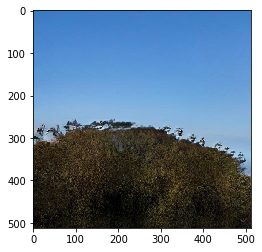

In [35]:
import matplotlib.pyplot as plt 
#generate images
sample_dialog = [
                {
                    "drawer": "what next",
                    "drawer_label": "Elicit_Information",
                    "image_semantic": "image_data/3b224bb2.png",
                    "image_synthetic": "image_data/cd4ee72e.jpg",
                    "teller": "very bottom is grass one sixth of image. then small line of trees",
                    "teller_label": "Describe_Image"
                },
                {
                    "drawer": "like this?",
                    "drawer_label": "Request_Correction",
                    "image_semantic": "image_data/88f04886.png",
                    "image_synthetic": "image_data/2d147646.jpg",
                    "teller": "higher trees on the right",
                    "teller_label": "Describe_Image"
                },
                {
                    "drawer": "thanks",
                    "drawer_label": "Other",
                    "image_semantic": "image_data/11530ed4.png",
                    "image_synthetic": "image_data/3f37b13c.jpg",
                    "teller": "yes very good",
                    "teller_label": "Other"
                }
            ]
sample_output_path = "gandraw_drawer_result"
for i,turn in enumerate(sample_dialog):
    input_text = turn["teller"]
    output_img, output_utt = drawer.generate_im_utt(input_text)
    print(output_utt)
    
    #Convert output_img to ByteString
    output_img = Image.fromarray(np.uint8(output_img))
    
    #convert output_img to ByteString
    output_be64 = img_to_bytes(output_img)
    #print(output_be64)
    #get the synthetic image from GauGAN
    returned_synthetic_img, correct_return = segmap_to_real(output_be64)
    if correct_return:
        plt.imshow(returned_synthetic_img)
        plt.show()
    break
#     output_img.save('/'.join([sample_output_path,"test_img_talktive_{}.png".format(i)]))
    